# **N400 ERP in Picture-Word Semantic Integration**

**The aim of this experiment is to study how the brain processes and integrates information**, specifically focusing on the brain's response to two conditions (match and mismatch).

The experiment involved participants viewing pictures of objects followed by spoken words, with some words matching the pictured object and others not matching. The researchers predicted the presence of an N400 ERP component for mismatched trials compared to matched ones, based on prior research. The N400 is a marker of brain processes related to semantic integration and detecting violations of meaning within a given context. 





In [4]:
# Import & Read Data

import mne
import numpy as np
import matplotlib.pyplot as plt

# Reduce extraneous MNE output
mne.set_log_level('error')

# Read raw EEG data
raw = mne.io.read_raw_brainvision('data/N400_dataset_14.vhdr', preload=True)





## Label Event Codes

Organizing and structuring the data, making it more convenient for subsequent analyses and interpretation by mapping numeric event codes to meaningful labels.

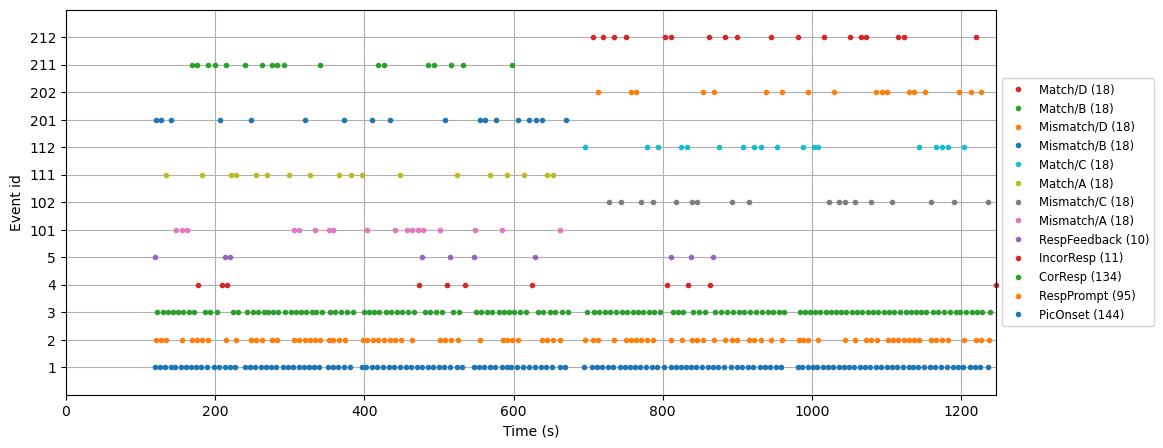

In [16]:


events, event_dict = mne.events_from_annotations(raw)

## Define the event mapping dictionary
event_mapping = {'PicOnset':1, 'RespPrompt':2, 'CorResp':3, 'IncorResp':4, 'RespFeedback':5,             
                 'Match/A':111, 'Match/B':211, 'Match/C':112, 'Match/D':212,
                 'Mismatch/A':101, 'Mismatch/B':201, 'Mismatch/C':102, 'Mismatch/D':202
                }


fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw.info['sfreq'], event_id=event_mapping, axes=ax)
plt.show()


### Filter the raw data

Reduce noise, extract specific frequency bands, enhance event-related potentials, remove artifacts, and prepare data for specific analyses.

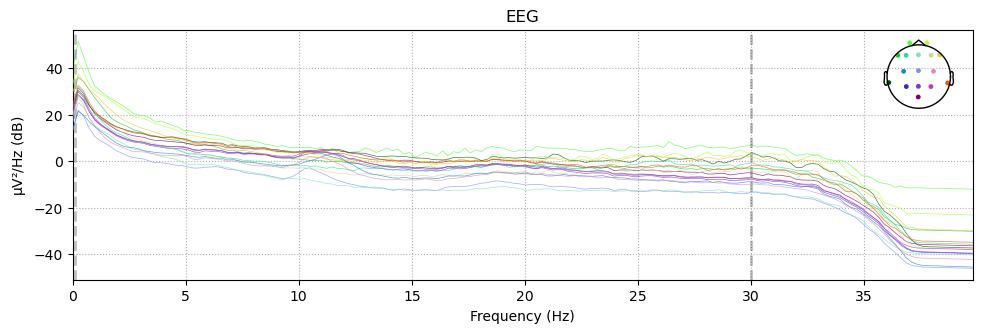

In [17]:

# Set electrode locations
montage = 'standard_1005' # Electrode position file
raw.set_montage(montage)

# Filter settings
low_cut = 0.1
hi_cut  = 30

raw_filt = raw.copy().filter(low_cut, hi_cut)

raw_filt.plot_psd(fmax=40,show=False);

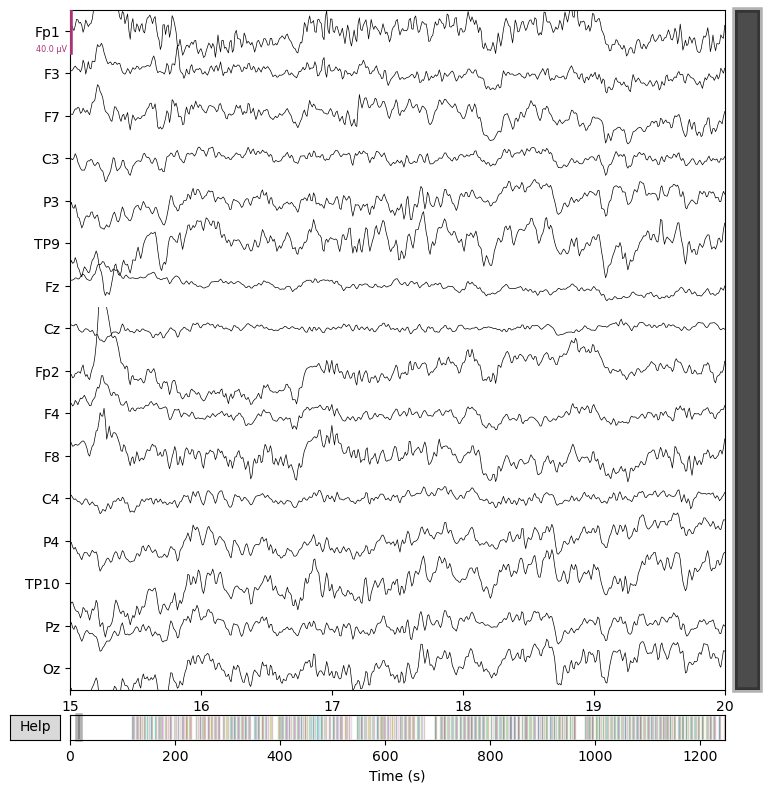

In [37]:
# # Visualizing the effects of filtering in the time domain

raw_filt.plot(start=15, duration=5);

### Segment the data into epochs

Essential for isolating and analyzing specific time periods of interest in an experiment. This process involves dividing continuous data (e.g., EEG or fMRI recordings) into smaller, non-overlapping time windows or epochs, each representing a specific event or condition.

In [38]:

# Epoching settings
tmin =  -.200  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (None, 0)

# Create epochs
epochs = mne.Epochs(raw_filt,
                    events, event_mapping,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True
                   ) 


epochs

Number of events,538
Events,CorResp: 134IncorResp: 11Match/A: 18Match/B: 18Match/C: 18Match/D: 18Mismatch/A: 18Mismatch/B: 18Mismatch/C: 18Mismatch/D: 18PicOnset: 144RespFeedback: 10RespPrompt: 95
Time range,-0.200 – 1.000 s
Baseline,-0.200 – 0.000 s


**The plot reveals significant ocular artifacts in the data,** evident by unusually high amplitude scales (100 µV vs. normal EEG 10–20 µV) and the presence of larger amplitudes around the eye channels, as indicated by color matching with electrode layout.

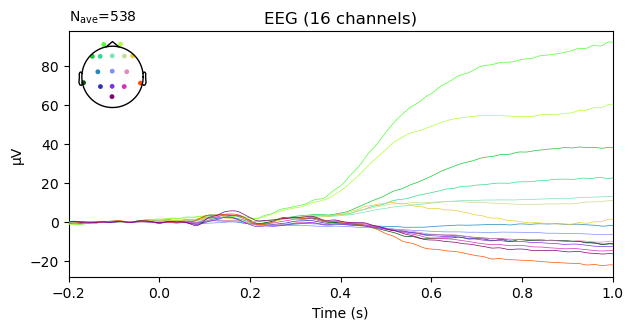

In [30]:
# Visualize average ERP across all conditions before artifact correction

epochs.average().plot(spatial_colors=True,show=False);

**The artifacts are focused over the electrodes close to the eyes.**

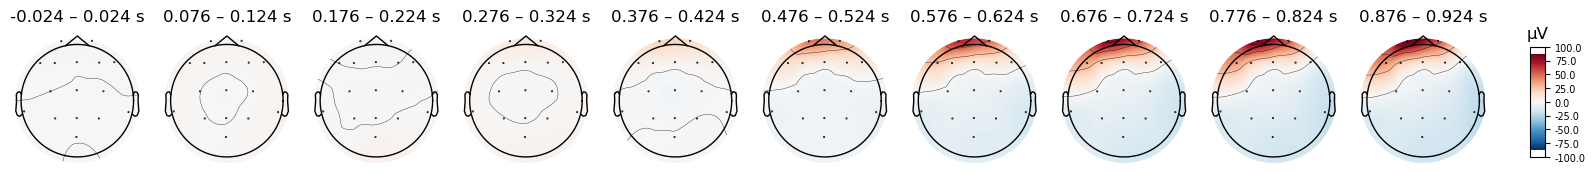

In [31]:
# Scalp topography maps

# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs.average().plot_topomap(times=times, average=0.050);

# Independent Component Analysis (ICA)

ICA is a valuable tool in EEG data analysis because it allows researchers to remove various artifacts without significantly altering the underlying brain activity of interest. It helps improve the quality of EEG data and enhances the accuracy of subsequent analyses, such as event-related potential (ERP) analysis and time-frequency analysis.

Estimating rejection dictionary for eeg
Rejection threshold: {'eeg': 0.00010817972166258349}


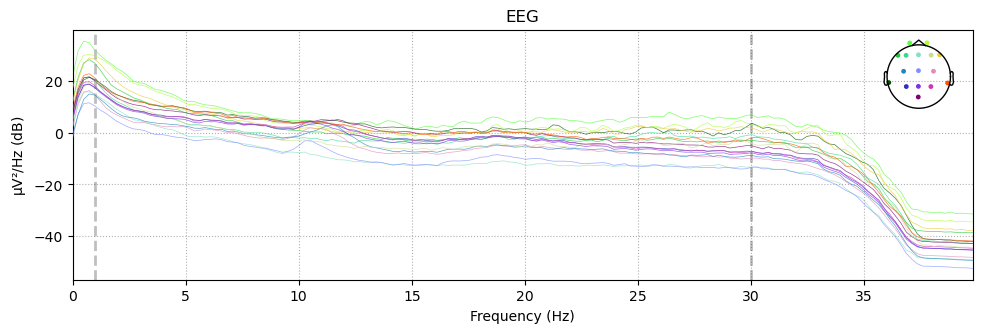

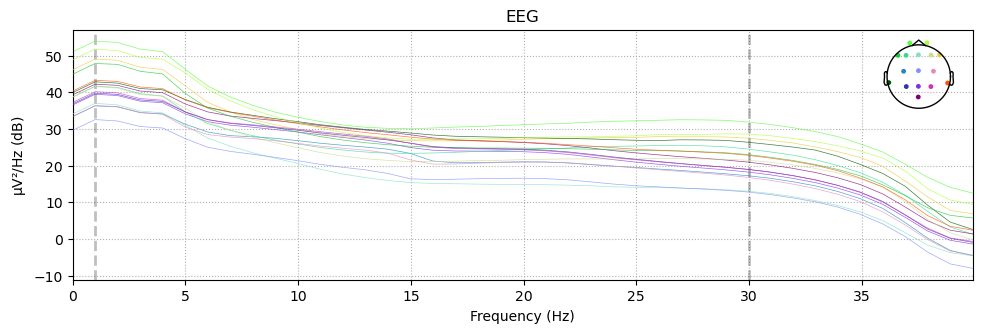

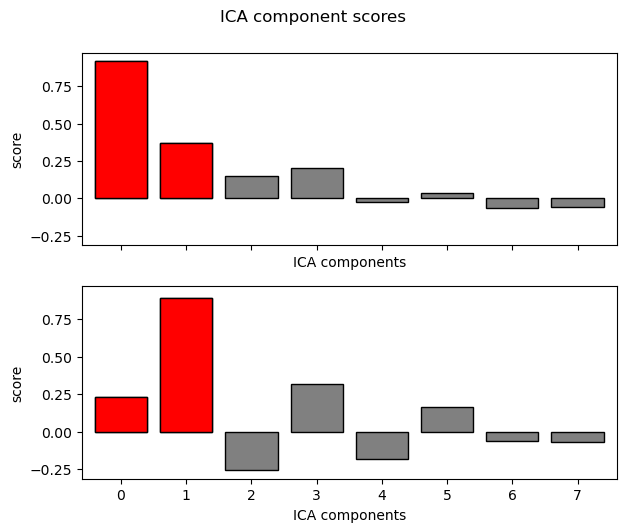

Method,fastica
Fit,31 iterations on epochs (624747 samples)
ICA components,8
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,ICA000ICA001


In [62]:

import os

# Participant ID code
p_id = 'N400_dataset_14'
data_dir = 'data'
raw_file = os.path.join(data_dir, p_id + '.vhdr')
raw_v2 = mne.io.read_raw_brainvision(raw_file, preload=True, verbose='error', eog=('EOG1', 'EOG2'))

# Set electrode locations
montage = mne.channels.make_standard_montage('standard_1005')
raw_v2.set_montage(montage)



# 1. Filtering Data for ICA:

ica_low_cut = 1.0  # For ICA, we filter out more low-frequency power
hi_cut = 30

raw_ica = raw_v2.copy().filter(ica_low_cut, hi_cut)


raw_ica.plot_psd(fmax=40,show=False);



# 2. Segment Data for ICA:

tstep = 1.0  # Break raw data into 1 s epochs
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica, tmin=0.0, tmax=tstep, baseline=None, preload=True)


epochs_ica.plot_psd(fmax=40,show=False);



# 3. Automatically determine a threshold

from autoreject import get_rejection_threshold

reject = get_rejection_threshold(epochs_ica); 

print('Rejection threshold:', reject)



# 4. Fit ICA to data:

random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

ica = mne.preprocessing.ICA(n_components=ica_n_components, random_state=random_state)

ica.fit(epochs_ica,reject=reject,tstep=tstep)



# 5. Identify EOG Artifacts from ICA Components:

ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(raw_ica, ch_name=['Fp1', 'F8'], threshold=ica_z_thresh)
ica.exclude = eog_indices

ica.plot_scores(eog_scores);




### Visualize ICA Components

ICA000 represents blink artifacts with prominent scalp topography above the eyes and horizontal "streaks" on some trials. ICA001 indicates horizontal eye movements with scalp activity over left and right anterior locations.

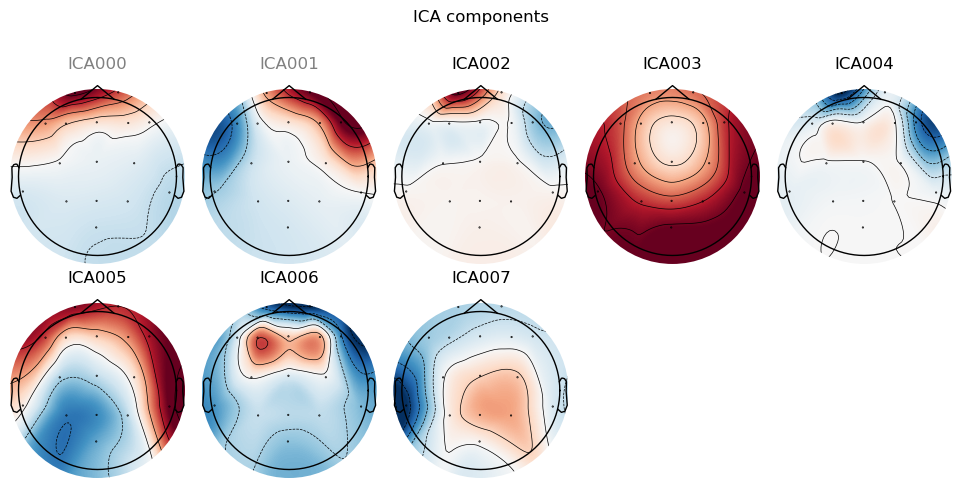

In [54]:

ica.plot_components();

## Apply correction to epochs

After correcting for artifacts, the average across all conditions shows typical ERP characteristics:

- Large-amplitude deflections at frontal channels are removed.
- The amplitude scale is within the typical range for ERPs.
- Early peaks, typical of responses to visual stimuli, are observed at around 75 ms, 150 ms (positive peak), and 225 ms (negative peak).

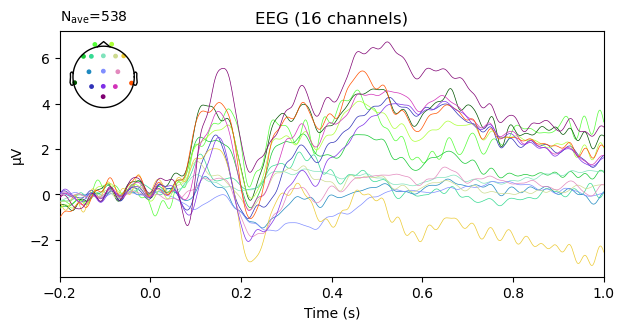

In [53]:
# Apply ICA to data

epochs_postica = ica.apply(epochs.copy())

# Visualize average ERP across all conditions after artifact correction
epochs_postica.average().plot(spatial_colors=True);

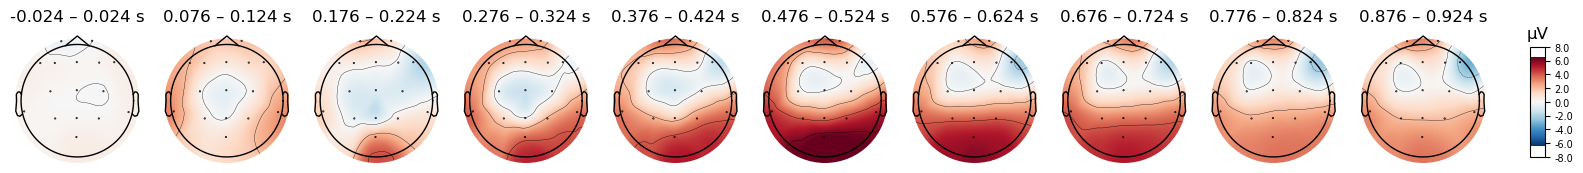

In [56]:
# Scalp topography maps

times = np.arange(0, tmax, 0.1) # Specify times (min, max, stepsize)

epochs_postica.average().plot_topomap(times=times, average=0.050);


Now the scalp distribution of the electrical potentials shouldn't be concentrated over the eyes. 

# Average Referencing in EEG Analysis

- Average referencing is a crucial step in EEG analysis to overcome reference electrode ambiguity.
- It removes bias and distortions introduced by single-reference recordings, enhancing the interpretability of neural activity patterns.
- By re-referencing EEG data to the average of all electrodes, researchers can focus on relative differences across electrodes, improving spatial resolution and enabling meaningful comparisons.
- Average referencing ensures consistency in event-related analyses and facilitates reliable comparisons across conditions and studies.

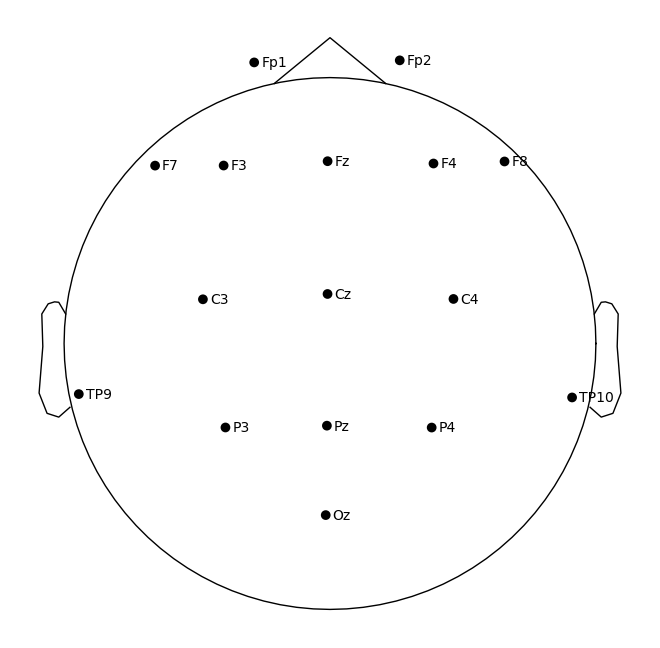

In [67]:
# Reference electrode was located at between electrodes Fz and Cz.

epochs_postica.plot_sensors(show_names=True);

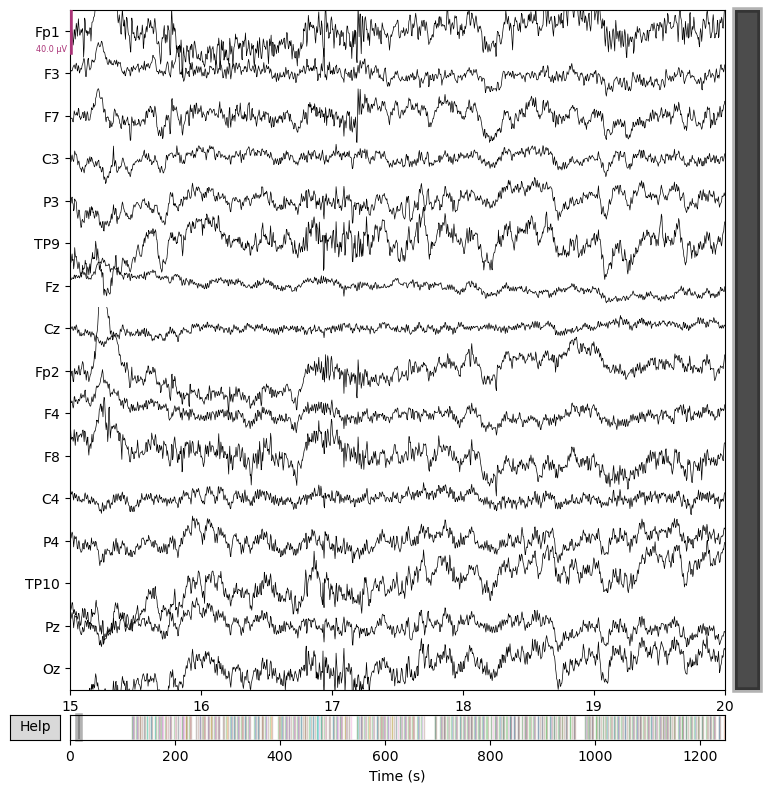

In [64]:
# Fz and Cz in the raw data (flatter)

raw.plot(start=15, duration=5); 

**The FCz reference location,** explains the white area between electrodes Fz and Cz in the scalp topography maps (re-plotted below), indicating values close to zero. The values are not exactly zero because MNE interpolates values between electrodes, estimating voltage values at other locations based on measurements at the known electrodes. Noise and slight differences in measurement locations contribute to non-zero estimated values.

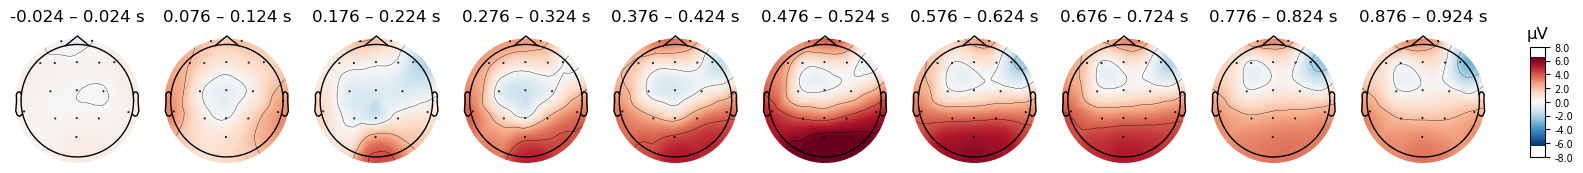

In [65]:
# Epochs post Independent Component Analysis

times = np.arange(0, epochs_postica.tmax, 0.1) #[min],[max],[stepsize]

epochs_postica.average().plot_topomap(times=times, average=0.050);

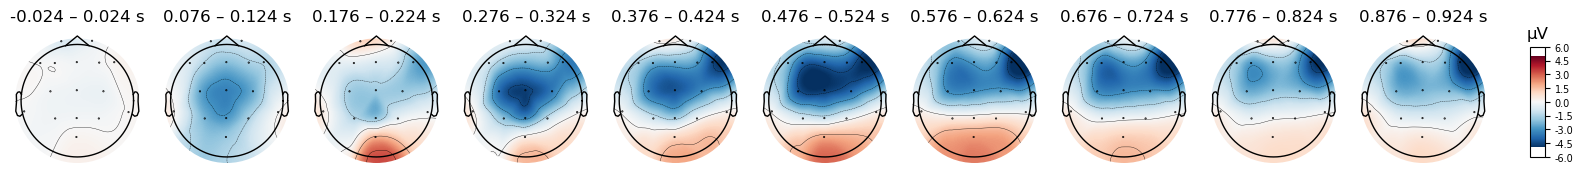

In [66]:
# Mastoid reference electrode

epochs_mastoidref = epochs_postica.set_eeg_reference(ref_channels=['TP9', 'TP10']);

epochs_mastoidref.average().plot_topomap(times=times, average=.050);

**Re-referencing electrodes (Tp9 and TP10) in the 10-20 system** is done to establish a new common reference point for EEG data analysis. The initial choice of reference electrode can influence the interpretation and analysis of EEG signals. By averaging the electrical potential from these mastoid electrodes and subtracting it from the other electrodes' values, we create a new reference point that helps mitigate the impact of the initial reference electrode choice and improves the consistency and interpretability of the EEG data.


- EEG measures electrical potential relative to a reference electrode, not absolute values.
- Re-referencing allows data to be transformed to any chosen electrode location after recording, reducing concerns about the initial reference electrode choice.

# Evoked objects

Essential for representing averaged ERP data, facilitating visualization, and enabling statistical comparisons across experimental conditions in EEG studies. They condense multiple trials into a single representation, simplifying analysis and interpretation.

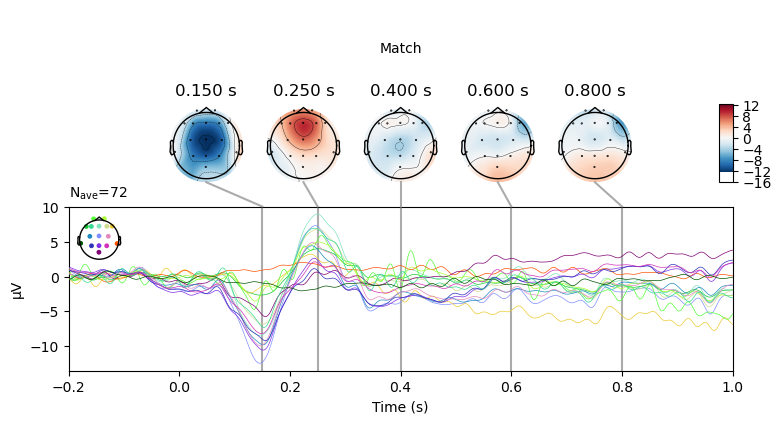

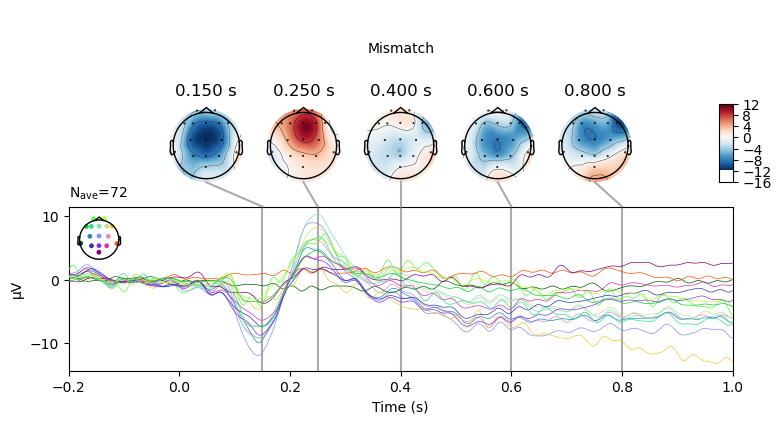

In [68]:
# Create Evoked objects

conditions = ['Match', 'Mismatch']

evokeds = {c:epochs_mastoidref[c].average() for c in conditions}

times = [.150, .250, .400, .600, .800]
for c in evokeds.keys():
    evokeds[c].plot_joint(times=times, title=c);

### Examining Contrasts in ERP Experiment

- ERP experiments are designed around *contrasts* between different conditions, such as match and mismatch items.
- In the present study, the focus is on the N400 component, which is larger (more negative) for mismatch than match items and is typically observed over the midline centre/posterior region of the scalp (using averaged-mastoid reference).


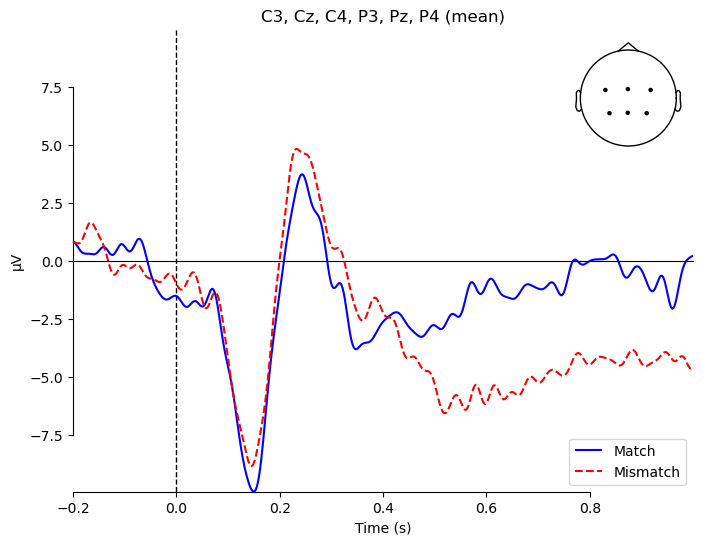

In [71]:

# Plot the data at electrode Cz, which typically shows the N400 effect.

roi = ['C3', 'Cz', 'C4', 
       'P3', 'Pz', 'P4']

color_dict = {'Match':'blue', 'Mismatch':'red'}
linestyle_dict = {'Match':'-', 'Mismatch':'--'}

mne.viz.plot_compare_evokeds(evokeds, combine='mean', 
                             legend='lower right',
                             picks=roi, show_sensors='upper right',
                             colors=color_dict,
                             linestyles=linestyle_dict);

In [72]:
# Create Evoked Variable

for condition in evokeds.keys():
    evokeds[condition].comment = condition

evokeds

{'Match': <Evoked | 'Match' (average, N=72), -0.2 – 1 s, baseline -0.2 – 0 s, 16 ch, ~105 kB>,
 'Mismatch': <Evoked | 'Mismatch' (average, N=72), -0.2 – 1 s, baseline -0.2 – 0 s, 16 ch, ~105 kB>}